1 Data Preparation

1.1 Load and Explore Data

- We begin by loading the dataset of sentiment-labeled news headlines. 
- Each row contains a headline and its corresponding sentiment label (neutral, positive, or negative). 
- After loading, we will inspect the structure of the data to understand its dimensions and data types.


In [2]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('all-data.csv', names=['Sentiment', 'Headline'],encoding='ISO-8859-1')

In [2]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [3]:
df.head()

,Sentiment,Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


- **Sentiment Distribution**: Understanding how many headlines fall under each sentiment category.
- **Headline Length: Average** length of the headlines, measured in word

In [4]:
# Descriptive statistics
print(df['Sentiment'].value_counts(normalize=True))
print(f"Total number of headlines: {len(df)}")
print(f"Average headline length: {np.mean([len(h.split()) for h in df['Headline']]):.2f} words")

Sentiment
neutral     0.594098
positive    0.281263
negative    0.124639
Name: proportion, dtype: float64
Total number of headlines: 4846
Average headline length: 23.10 words


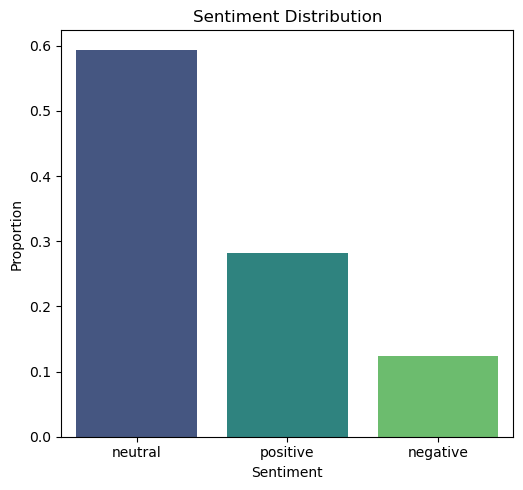

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = df['Sentiment'].value_counts(normalize=True)
total_headlines = len(df)
average_headline_length = np.mean([len(h.split()) for h in df['Headline']])

plt.figure(figsize=(10, 5))

#sentiment distribution
plt.subplot(1, 2, 1)
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')


plt.tight_layout()
plt.show()

- The x-axis represents the sentiment categories, and the y-axis shows the normalized count (proportion) of each category.

 **1.1.1 Data Cleaning**

- Next, we'll clean the dataset by removing duplicate rows and ensuring there are no empty headlines. 
- This step is crucial to avoid bias introduced by repeated or empty data.

In [12]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
duplicate_count

Number of duplicate entries: 6


In [13]:
# Remove duplicates
df = df.drop_duplicates()

In [17]:
# Check if any entries have only spaces 
empty_headlines = df['Headline'].apply(lambda x: x.strip()) == ''
empty_headlines.sum()

0

In [18]:
# Clean dataset overview
print(f"Total number of headlines after cleaning: {len(df)}")

Total number of headlines after cleaning: 4840


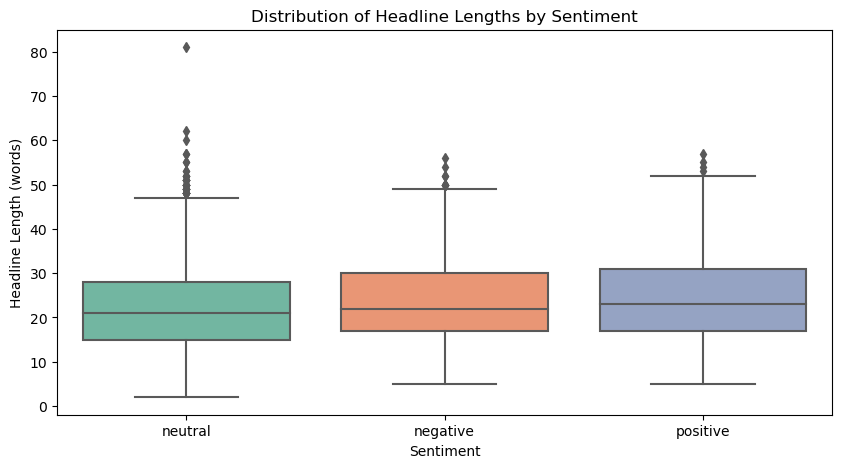

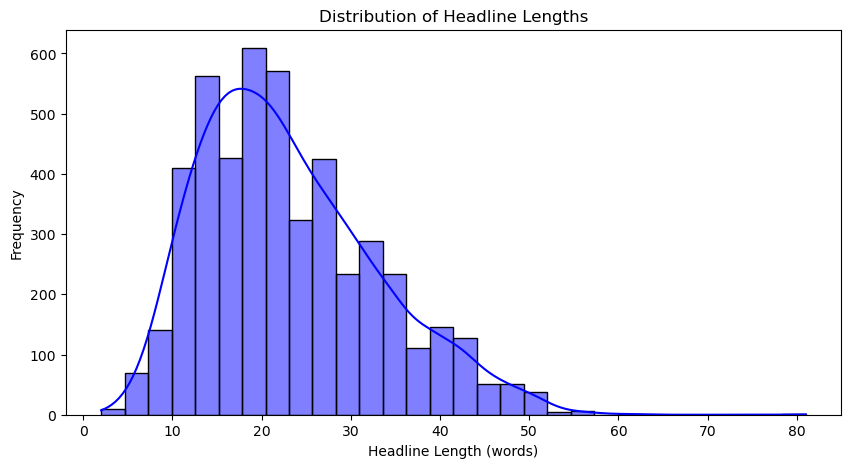

In [19]:
# Calculate headline length
df['Headline_Length'] = df['Headline'].apply(lambda x: len(x.split()))

# Boxplot of headline lengths by sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x='Sentiment', y='Headline_Length', data=df, palette='Set2')
plt.title('Distribution of Headline Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Headline Length (words)')
plt.show()

# Distribution of headline lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['Headline_Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length (words)')
plt.ylabel('Frequency')
plt.show()


- This boxplot visualizes the distribution of headline lengths categorized by sentiment. It helps to identify trends and variations in headline lengths across different sentiment labels.
- The histogram depicts the frequency distribution of headline lengths, providing insights into the typical lengths of headlines in the dataset.


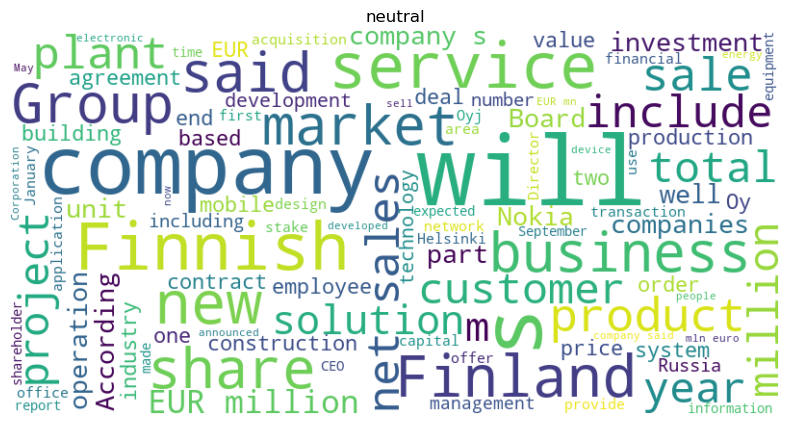

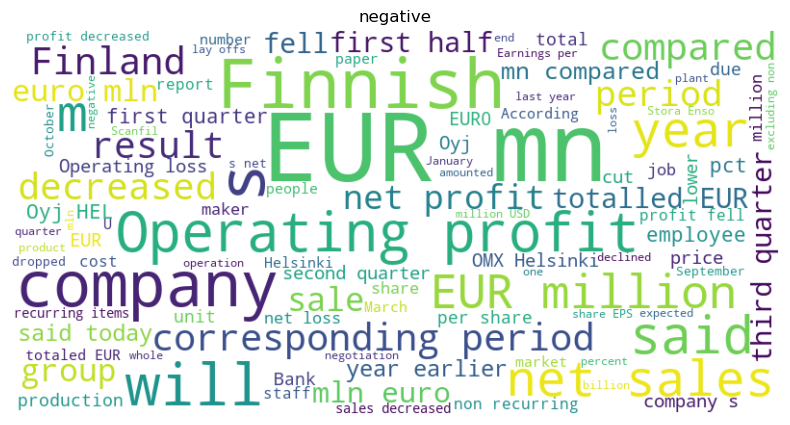

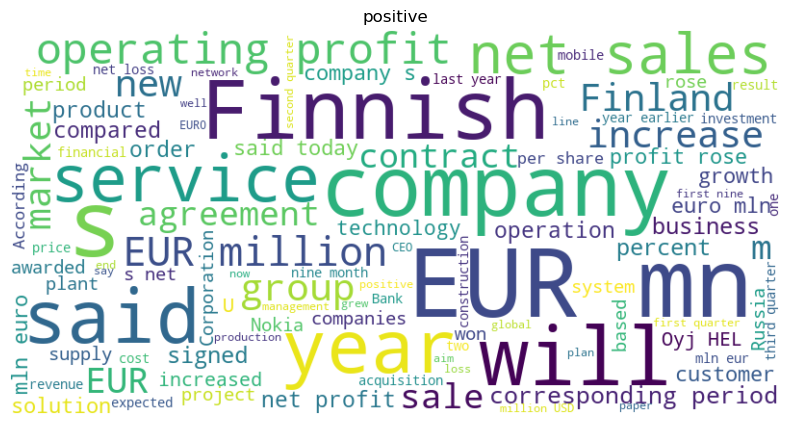

In [22]:
from wordcloud import WordCloud

#  word cloud for sentiments
def generate_wordcloud(sentiment):
    text = ' '.join(df[df['Sentiment'] == sentiment]['Headline'])
    wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(sentiment)
    plt.show()
for sentiment in df['Sentiment'].unique():
    generate_wordcloud(sentiment)


1.1.2 Text Preprocessing

preprocessing stage includes converting headlines to lowercase, removing punctuation, and filtering out stopwords, which are common words that don't carry significant meaning. The cleaned headlines will be more suitable for model training.


In [ ]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Convert headlines to lowercase
df['Headline'] = df_cleaned['Headline'].str.lower()

# Remove punctuation
df['Headline'] = df_cleaned['Headline'].str.translate(str.maketrans('', '', string.punctuation))

# Remove stopwords
stop_words = set(stopwords.words('english'))
df_cleaned['Headline'] = df_cleaned['Headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Verify the preprocessing
df_cleaned.head()

1.2. Data Preprocessing

Here, we tokenize the headlines and encode the sentiment labels into numerical format. The dataset is then split into training, validation, and test sets for model evaluation.


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Download necessary NLTK data
nltk.download('punkt')

# Tokenization and encoding sentiments
headlines = df['Headline'].tolist()
sentiments = df['Sentiment'].tolist()

# Encode sentiments
label_encoder = LabelEncoder()
encoded_sentiments = label_encoder.fit_transform(sentiments)

# Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(headlines, encoded_sentiments, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2 Doc2Vec and LSTM

2.1. Train Doc2Vec Model

- We will now prepare the data for the Doc2Vec model. This involves tokenizing each headline (converting the text into individual words) and tagging each document (headline) for training. 
- The Doc2Vec model will be trained to create vector representations (embeddings) for each headline.


In [4]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Prepare tagged data for Doc2Vec
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(X_train)]

# Train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Generate embeddings for train, validation, and test sets
X_train_embed = np.array([doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in X_train])
X_val_embed = np.array([doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in X_val])
X_test_embed = np.array([doc2vec_model.infer_vector(word_tokenize(doc.lower())) for doc in X_test])


2.2. Reshape Data for LSTM Input

The generated embeddings are reshaped to fit the input requirements of the LSTM model.


In [5]:
# Reshape embeddings for LSTM input
X_train_embed = X_train_embed.reshape((X_train_embed.shape[0], X_train_embed.shape[1], 1))
X_val_embed = X_val_embed.reshape((X_val_embed.shape[0], X_val_embed.shape[1], 1))
X_test_embed = X_test_embed.reshape((X_test_embed.shape[0], X_test_embed.shape[1], 1))


2.3. Build and Train LSTM Model

We define and compile an LSTM model, specifying the structure and loss function. The model is then trained on the training set with validation to monitor its performance.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Define the LSTM model
num_classes = len(set(encoded_sentiments))
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_embed.shape[1], 1), return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encoding for the output labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Train the model
history = lstm_model.fit(X_train_embed, y_train_cat, validation_data=(X_val_embed, y_val_cat), epochs=10, batch_size=32)


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.5865 - loss: 0.9874 - val_accuracy: 0.6005 - val_loss: 0.9192
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5873 - loss: 0.9378 - val_accuracy: 0.4265 - val_loss: 1.0628
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5786 - loss: 0.9245 - val_accuracy: 0.5979 - val_loss: 0.9247
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5996 - loss: 0.8962 - val_accuracy: 0.5992 - val_loss: 0.9100
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5882 - loss: 0.9057 - val_accuracy: 0.5979 - val_loss: 0.9096
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5953 - loss: 0.8960 - val_accuracy: 0.5902 - val_loss: 0.9165
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5997 - loss: 0.8850 - val_accuracy: 0.5838 - val_loss: 0.9162
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.5933 - loss: 0.9015 - val_accuracy: 0.5799 -

2.4. Evaluate LSTM Model

The evaluation step assesses the trained LSTM model on the test set, providing accuracy and loss metrics to gauge its performance.


In [7]:
test_loss, test_accuracy = lstm_model.evaluate(X_test_embed, to_categorical(y_test, num_classes))
print(f"LSTM Test accuracy: {test_accuracy:.4f}")
print(f"LSTM Test loss: {test_loss:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6129 - loss: 0.9039
LSTM Test accuracy: 0.5990
LSTM Test loss: 0.9026


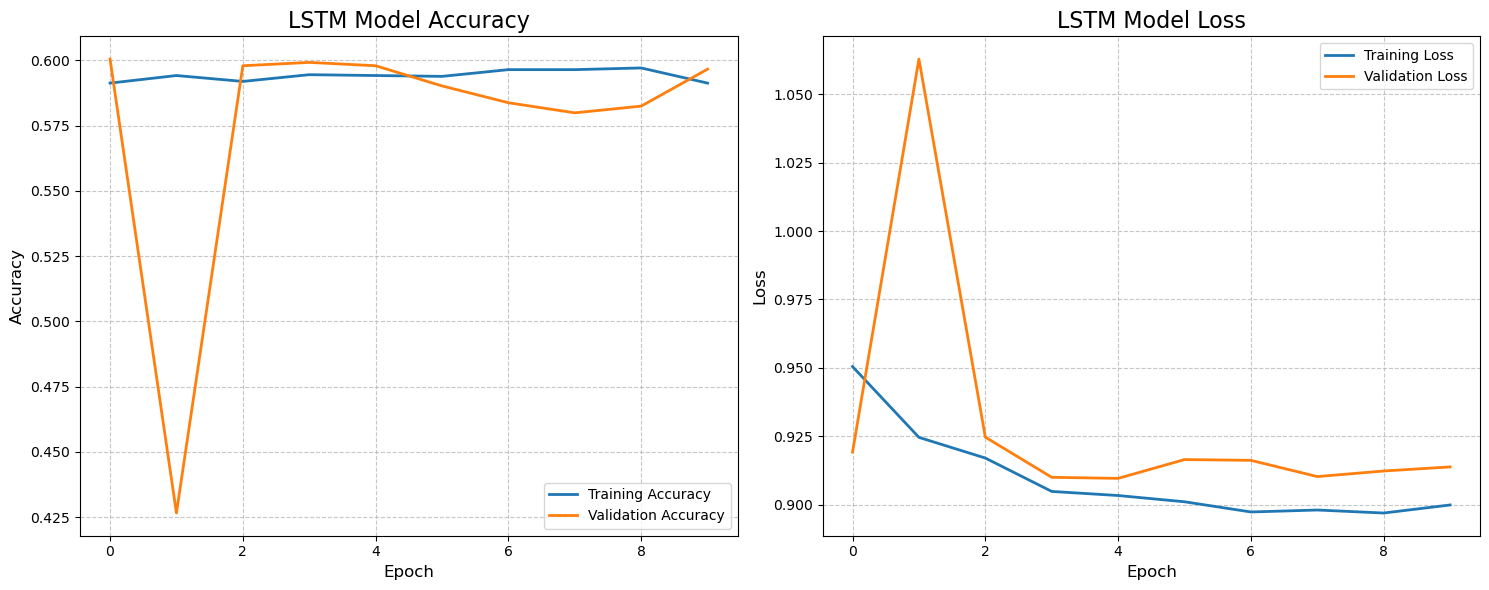

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('LSTM Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Model Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()  

The training and validation accuracy and loss plots help us visualize the model's performance over epochs. We look for trends such as convergence and any signs of overfitting.


3 LLM Approach: BERT

3.1 Tokenization

##### 3.1 Tokenization

 we utilize the BERT tokenizer to preprocess our datasets for the BERT model. Tokenization is an essential step in natural language processing (NLP), as it transforms raw text into a format that can be understood by the model.

1. We load the pre-trained BERT tokenizer using the `BertTokenizer` class from the `transformers` library. The `bert-base-uncased` model is used here, which is a lower-cased version of the BERT model, making it suitable for various NLP tasks.

2. We then tokenize our training, validation, and test datasets (`X_train`, `X_val`, and `X_test`). The tokenization process includes:
   - **Truncation**: Longer sentences are truncated to ensure they fit within the maximum length of 128 tokens.


In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the datasets
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)


c:\Users\Admin\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


3.2. Prepare Data for BERT

We create Tensor datasets for both the training and validation sets using `torch.utils.data.TensorDataset`. Each dataset consists of:
   - **Input IDs**: The tokenized representations of the input sentences (from `train_encodings['input_ids']` and `val_encodings['input_ids']`).
   - **Attention Masks**: A binary mask indicating which tokens should be attended to (from `train_encodings['attention_mask']` and `val_encodings['attention_mask']`).
   - **Labels**: The target labels for classification (stored in `y_train` for training and `y_val` for validation).

In [ ]:
import torch

# Create Tensor datasets for training and validation
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(y_train)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(y_val)
)

In [ ]:
#pip install torch

3.3. Build and Train BERT Model

 We define a custom dataset class to manage tokenized inputs and labels, then create training and validation datasets using the Hugging Face library.  We configure the training parameters, including batch sizes and epochs, and create a `Trainer` instance to facilitate the training process. Finally, we initiate the training with `trainer.train()`, allowing the model to learn from the dataset.


In [16]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HFDataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': y_train
})
val_dataset = HFDataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': y_val
})

bert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)
bert_model.to(device)  # Move model to GPU if available

# Define training arguments with optimized settings
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    metric_for_best_model="loss",
    greater_is_better=False,
    dataloader_num_workers=2,  
    gradient_accumulation_steps=4, 
)

# Create a Trainer instance
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/291 [00:00<?, ?it/s]

{'loss': 0.7842, 'learning_rate': 5e-05, 'epoch': 1.03}
{'loss': 0.3625, 'learning_rate': 2.382198952879581e-05, 'epoch': 2.06}
{'train_runtime': 9241.1932, 'train_samples_per_second': 1.006, 'train_steps_per_second': 0.031, 'train_loss': 0.45171830088821885, 'epoch': 3.0}


TrainOutput(global_step=291, training_loss=0.45171830088821885, metrics={'train_runtime': 9241.1932, 'train_samples_per_second': 1.006, 'train_steps_per_second': 0.031, 'train_loss': 0.45171830088821885, 'epoch': 3.0})

3.4. Evaluate BERT Model

In [18]:
# Convert the test data to a HuggingFace Dataset
test_dataset = HFDataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': y_test
})

# Evaluate BERT model on the test set
bert_predictions = trainer.predict(test_dataset)
bert_predictions = np.argmax(bert_predictions.predictions, axis=1)

# accuracy
bert_accuracy = np.mean(bert_predictions == y_test)
print(f"BERT Test accuracy: {bert_accuracy:.4f}")


  0%|          | 0/61 [00:01<?, ?it/s]

BERT Test accuracy: 0.8567


4 Comparison of Models

4.1 Generate Classification Reports

In [19]:
from sklearn.metrics import classification_report

# Get predictions from the LSTM model
lstm_predictions = np.argmax(lstm_model.predict(X_test_embed), axis=1)

print("LSTM Classification Report:")
print(classification_report(y_test, lstm_predictions, target_names=label_encoder.classes_))

print("\nBERT Classification Report:")
print(classification_report(y_test, bert_predictions, target_names=label_encoder.classes_))


31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.37      0.20      0.26       110
     neutral       0.61      0.98      0.75       571
    positive       0.00      0.00      0.00       289

    accuracy                           0.60       970
   macro avg       0.33      0.39      0.34       970
weighted avg       0.40      0.60      0.47       970


BERT Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.76      0.82       110
     neutral       0.88      0.90      0.89       571
    positive       0.80      0.81      0.80       289

    accuracy                           0.86       970
   macro avg       0.85      0.82      0.84       970
weighted avg       0.86      0.86      0.86       970



c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4.2. Visualize Confusion Matrices

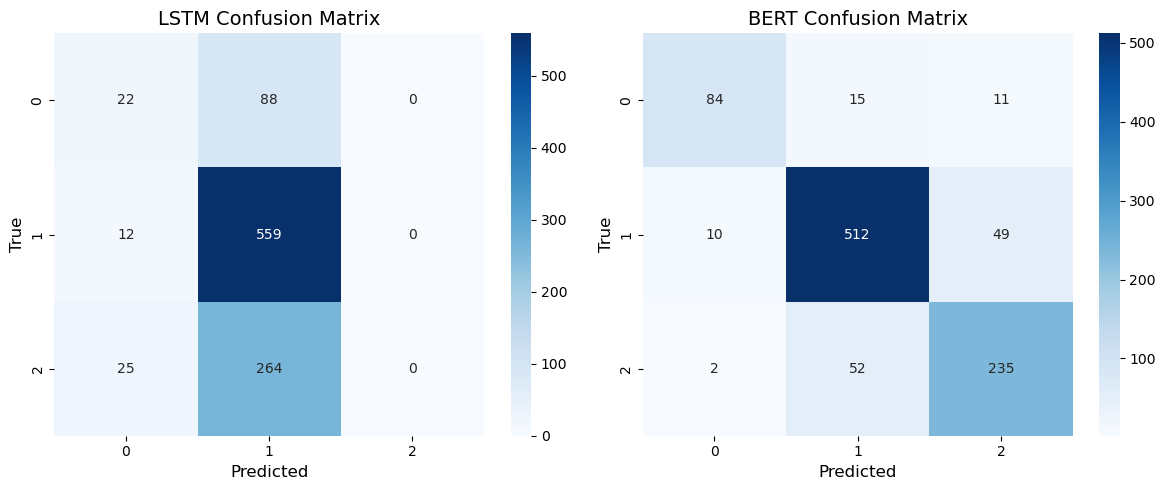

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrices
plt.figure(figsize=(12, 5))

# LSTM Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, lstm_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

# BERT Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, bert_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('BERT Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

plt.tight_layout()
plt.show()  

4.3 Testing the LSTM Model on Custom Text

In [33]:
def test_lstm_model(text, model, doc2vec_model, label_encoder):
    tokens = word_tokenize(text.lower())
    embedding = doc2vec_model.infer_vector(tokens).reshape(1, -1, 1)
    
    prediction = model.predict(embedding)
    predicted_class = np.argmax(prediction)
    
    predicted_sentiment = label_encoder.inverse_transform([predicted_class])
    
    return predicted_sentiment[0]

custom_text = "The company has reported strong growth in the past quarter."
predicted_sentiment = test_lstm_model(custom_text, lstm_model, doc2vec_model, label_encoder)
print(f"LSTM Model predicted sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
LSTM Model predicted sentiment: neutral


4.4 Testing the BERT Model on Custom Text

In [29]:
from transformers import BertTokenizer
import torch

def test_bert_model(text, model, tokenizer, label_encoder):
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    
    predicted_sentiment = label_encoder.inverse_transform([predicted_class])
    
    return predicted_sentiment[0]

custom_text_bert = "The company has launched an innovative product that has received great feedback."
predicted_sentiment_bert = test_bert_model(custom_text_bert, bert_model, tokenizer, label_encoder)
print(f"BERT Model predicted sentiment: {predicted_sentiment_bert}")


BERT Model predicted sentiment: positive


> it is clear that BERT is significantly outperforming the LSTM model in terms of precision, recall, f1-score, and overall accuracy.